# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import datetime
import numpy as np

from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression

import seaborn as sns
sns.set()

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio data Analysis

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
#Checking count of records and columns
portfolio.shape

(10, 6)

In [4]:
#Checking offer_types
portfolio['offer_type'].unique()

array(['bogo', 'informational', 'discount'], dtype=object)

In [5]:
#we dont have any duplicate data
#Checking uniques on id column
portfolio['id'].nunique()

10

In [6]:
portfolio.groupby('offer_type').count()

,reward,channels,difficulty,duration,id
offer_type,,,,,
bogo,4,4,4,4,4
discount,4,4,4,4,4
informational,2,2,2,2,2


In [7]:
#split the channels column to multiple columns
portfolio['channel_email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['channel_mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['channel_social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio['channel_web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)

In [8]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [9]:
# drop channels column
portfolio.drop('channels',axis=1,inplace=True)

In [10]:
portfolio

,reward,difficulty,duration,offer_type,id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [11]:
def create_dictory(df,column_name):
    
    #Create list for perticular column
    list_values = df[column_name].unique().tolist()
    
    #Generating Dictory
    Generate_Dictory = {column_name : {value: num \
                                       for value,num in zip(list_values,list(range(1,len(list_values)+1)))
                                      }
                       }
    return Generate_Dictory

In [12]:
#create dictory for id column  
replace_id_column = create_dictory(portfolio,'id')

#Replace id column values to dictory
portfolio.replace(replace_id_column, inplace=True)


#rename id column to offer_id
portfolio.rename(columns={'id':'offer_id'},inplace=True)

portfolio

,reward,difficulty,duration,offer_type,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,bogo,1,1,1,1,0
1,10,10,5,bogo,2,1,1,1,1
2,0,0,4,informational,3,1,1,0,1
3,5,5,7,bogo,4,1,1,0,1
4,5,20,10,discount,5,1,0,0,1
5,3,7,7,discount,6,1,1,1,1
6,2,10,10,discount,7,1,1,1,1
7,0,0,3,informational,8,1,1,1,0
8,5,5,5,bogo,9,1,1,1,1
9,2,10,7,discount,10,1,1,0,1


In [13]:
#create dictory for id column  
replace_offer_type_column = create_dictory(portfolio,'offer_type')

#Replace id column values to dictory
portfolio.replace(replace_offer_type_column, inplace=True)


#rename id column to offer_id
portfolio.rename(columns={'offer_type':'offer_type_id'},inplace=True)

portfolio

,reward,difficulty,duration,offer_type_id,offer_id,channel_email,channel_mobile,channel_social,channel_web
0,10,10,7,1,1,1,1,1,0
1,10,10,5,1,2,1,1,1,1
2,0,0,4,2,3,1,1,0,1
3,5,5,7,1,4,1,1,0,1
4,5,20,10,3,5,1,0,0,1
5,3,7,7,3,6,1,1,1,1
6,2,10,10,3,7,1,1,1,1
7,0,0,3,2,8,1,1,1,0
8,5,5,5,1,9,1,1,1,1
9,2,10,7,3,10,1,1,0,1


In [14]:
#convert duration to hours
portfolio['duration_h'] = portfolio['duration'] * 24

#drop duration column
portfolio.drop('duration',axis=1,inplace=True)

In [15]:
#checking column types
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
reward            10 non-null int64
difficulty        10 non-null int64
offer_type_id     10 non-null int64
offer_id          10 non-null int64
channel_email     10 non-null int64
channel_mobile    10 non-null int64
channel_social    10 non-null int64
channel_web       10 non-null int64
duration_h        10 non-null int64
dtypes: int64(9)
memory usage: 848.0 bytes


In [88]:
portfolio.head()

,reward,difficulty,offer_type_id,offer_id,channel_email,channel_mobile,channel_social,channel_web,duration_h
0,10,10,1,1,1,1,1,0,168
1,10,10,1,2,1,1,1,1,120
2,0,0,2,3,1,1,0,1,96
3,5,5,1,4,1,1,0,1,168
4,5,20,3,5,1,0,0,1,240


# Profile data Analysis

In [17]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [18]:
#Checking count of records and columns
profile.shape

(17000, 5)

In [19]:
# convert the values into appropriate formate
profile['new_became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile

,gender,age,id,became_member_on,income,new_became_member_on
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04
...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07


In [20]:
#create new columns based on became_member_on to member_year, member_month, member_day
profile['member_year'] = profile['new_became_member_on'].dt.year

profile['member_month'] = profile['new_became_member_on'].dt.month

profile['member_day'] = profile['new_became_member_on'].dt.day

In [21]:
profile

,gender,age,id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,2017,8,4
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07,2016,3,7


In [23]:
#rename id column to customer_id
profile.rename(columns={'id':'customer_id'},inplace=True)
profile

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,2017-02-12,2017,2,12
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,2017-07-15,2017,7,15
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,2018-07-12,2018,7,12
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,2017-05-09,2017,5,9
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,2017-08-04,2017,8,4
...,...,...,...,...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0,2018-06-04,2018,6,4
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0,2018-07-13,2018,7,13
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0,2017-01-26,2017,1,26
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0,2016-03-07,2016,3,7


In [24]:
#create dictory for customer_id column  
replace_customer_id_column = create_dictory(profile,'customer_id')

#Replace id column values to dictory
profile.replace(replace_customer_id_column, inplace=True)
profile

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
0,None,118,1,20170212,NaN,2017-02-12,2017,2,12
1,F,55,2,20170715,112000.0,2017-07-15,2017,7,15
2,None,118,3,20180712,NaN,2018-07-12,2018,7,12
3,F,75,4,20170509,100000.0,2017-05-09,2017,5,9
4,None,118,5,20170804,NaN,2017-08-04,2017,8,4
...,...,...,...,...,...,...,...,...,...
16995,F,45,16996,20180604,54000.0,2018-06-04,2018,6,4
16996,M,61,16997,20180713,72000.0,2018-07-13,2018,7,13
16997,M,49,16998,20170126,73000.0,2017-01-26,2017,1,26
16998,F,83,16999,20160307,50000.0,2016-03-07,2016,3,7


In [25]:
#Checking unique values for gender columns
profile['gender'].unique()

array([None, 'F', 'M', 'O'], dtype=object)

In [26]:
#checking count on gender column
profile.groupby('gender').count()

,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
gender,,,,,,,,
F,6129,6129,6129,6129,6129,6129,6129,6129
M,8484,8484,8484,8484,8484,8484,8484,8484
O,212,212,212,212,212,212,212,212


In [27]:
#here we did not get 118 age 

# Checking count based on age column

#There is no gender for age 118
profile.groupby('age').count()

,gender,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
age,,,,,,,,
18,70,70,70,70,70,70,70,70
19,135,135,135,135,135,135,135,135
20,135,135,135,135,135,135,135,135
21,140,140,140,140,140,140,140,140
22,131,131,131,131,131,131,131,131
...,...,...,...,...,...,...,...,...
98,5,5,5,5,5,5,5,5
99,5,5,5,5,5,5,5,5
100,12,12,12,12,12,12,12,12


In [28]:
#Remove records where age = 118
profile.dropna(inplace=True)

In [29]:
#Checking null values after droping the records related to age = 118
profile[profile['income'].isna()]

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day


In [30]:
profile[profile['became_member_on'].isna()]

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day


In [31]:
profile[profile['gender'].isna()]

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day


In [32]:
profile[profile['age'].isna()]

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day


In [33]:
profile[profile['customer_id'].isna()]

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day


In [34]:
profile

,gender,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
1,F,55,2,20170715,112000.0,2017-07-15,2017,7,15
3,F,75,4,20170509,100000.0,2017-05-09,2017,5,9
5,M,68,6,20180426,70000.0,2018-04-26,2018,4,26
8,M,65,9,20180209,53000.0,2018-02-09,2018,2,9
12,M,58,13,20171111,51000.0,2017-11-11,2017,11,11
...,...,...,...,...,...,...,...,...,...
16995,F,45,16996,20180604,54000.0,2018-06-04,2018,6,4
16996,M,61,16997,20180713,72000.0,2018-07-13,2018,7,13
16997,M,49,16998,20170126,73000.0,2017-01-26,2017,1,26
16998,F,83,16999,20160307,50000.0,2016-03-07,2016,3,7


In [35]:
#checking type of genders
profile['gender'].unique()

array(['F', 'M', 'O'], dtype=object)

In [36]:
#create dictory for list of genders
replace_gender_column = create_dictory(profile,'gender')

#replace values to gender dictory
profile.replace(replace_gender_column, inplace=True)


#rename gender column to gender_type
profile.rename(columns={'gender':'gender_type'},inplace=True)

profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11
...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7


In [37]:
# adding a new column 'membership_days' ,that will present the number of days since the customer become a member
profile['membership_days'] = datetime.datetime.today().date() - profile['new_became_member_on'].dt.date

# removing the 'days' unit
profile['membership_days'] = profile['membership_days'].dt.days

# creating a new column 'member_type' representing the type of the member: new, regular or loyal depending on the number of his 'membership_days'
profile['member_type'] = pd.cut(profile['membership_days'], bins=[390, 1000, 1600, 2500],labels=['new', 'regular', 'loyal'])

profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,regular
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,regular
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,regular
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,regular
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,regular
...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,new
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,new
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,regular
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,loyal


In [38]:
# Create dicotry for  member_type column values 
replace_member_type_column = create_dictory(profile,'member_type')

#replace member_type to member_type dictory
profile.replace(replace_member_type_column, inplace=True)

#rename gender member_type to member_typeid
profile.rename(columns={'member_type':'member_type_id'},inplace=True)
profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type_id
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,1
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,1
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,1
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,1
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,1
...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,4
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,4
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,1
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,3


In [39]:
# creating a new column representing the age group to which the customer belongs 
profile['income_range'] = pd.cut(profile['income'], bins=[29999, 60000, 90000, 120001],labels=['average', 'above-average', 'high'])
profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type_id,income_range
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,1,high
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,1,high
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,1,above-average
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,1,average
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,1,average
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,4,average
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,4,above-average
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,1,above-average
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,3,average


In [40]:
# create dictory for income_range column values 
replace_income_range_column = create_dictory(profile,'income_range')

#replace member_type to member_type dictory
profile.replace(replace_income_range_column, inplace=True)

#rename inccome_range column to income_range_id
profile.rename(columns={'income_range':'income_range_id'},inplace=True)

profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type_id,income_range_id
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,1,1
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,1,1
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,1,2
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,1,3
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,4,3
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,4,2
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,1,2
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,3,3


In [41]:
# creating a new column representing the age group to which the customer belongs 
profile['age_group'] = pd.cut(profile['age'], \
                              bins=[17, 22, 35, 60, 103],\
                              labels=['teenage', 'young-adult', 'adult', 'elderly'])

profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,1,1,adult
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,1,1,elderly
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,1,2,elderly
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,1,3,elderly
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,1,3,adult
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,4,3,adult
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,4,2,elderly
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,1,2,adult
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,3,3,elderly


In [42]:
# Create dicotry for age_group column values 
replace_age_group_column = create_dictory(profile,'age_group')

#replace age_group values to age_group dictory
profile.replace(replace_age_group_column, inplace=True)

#rename gender member_type to member_typeid
profile.rename(columns={'age_group':'age_group_id'},inplace=True)

profile

,gender_type,age,customer_id,became_member_on,income,new_became_member_on,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
1,1,55,2,20170715,112000.0,2017-07-15,2017,7,15,1286,1,1,1
3,1,75,4,20170509,100000.0,2017-05-09,2017,5,9,1353,1,1,2
5,2,68,6,20180426,70000.0,2018-04-26,2018,4,26,1001,1,2,2
8,2,65,9,20180209,53000.0,2018-02-09,2018,2,9,1077,1,3,2
12,2,58,13,20171111,51000.0,2017-11-11,2017,11,11,1167,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,20180604,54000.0,2018-06-04,2018,6,4,962,4,3,1
16996,2,61,16997,20180713,72000.0,2018-07-13,2018,7,13,923,4,2,2
16997,2,49,16998,20170126,73000.0,2017-01-26,2017,1,26,1456,1,2,1
16998,1,83,16999,20160307,50000.0,2016-03-07,2016,3,7,1781,3,3,2


In [43]:
# Removed unwanted columns
profile.drop(columns = ['became_member_on','new_became_member_on'],axis=1,inplace=True)

In [44]:
#checking data types
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 11 columns):
gender_type        14825 non-null int64
age                14825 non-null int64
customer_id        14825 non-null int64
income             14825 non-null float64
member_year        14825 non-null int64
member_month       14825 non-null int64
member_day         14825 non-null int64
membership_days    14825 non-null int64
member_type_id     14825 non-null int64
income_range_id    14825 non-null int64
age_group_id       14825 non-null int64
dtypes: float64(1), int64(10)
memory usage: 1.4 MB


In [45]:
profile

,gender_type,age,customer_id,income,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
1,1,55,2,112000.0,2017,7,15,1286,1,1,1
3,1,75,4,100000.0,2017,5,9,1353,1,1,2
5,2,68,6,70000.0,2018,4,26,1001,1,2,2
8,2,65,9,53000.0,2018,2,9,1077,1,3,2
12,2,58,13,51000.0,2017,11,11,1167,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,54000.0,2018,6,4,962,4,3,1
16996,2,61,16997,72000.0,2018,7,13,923,4,2,2
16997,2,49,16998,73000.0,2017,1,26,1456,1,2,1
16998,1,83,16999,50000.0,2016,3,7,1781,3,3,2


In [87]:
profile.head()

,gender_type,age,customer_id,income,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
1,1,55,2,112000.0,2017,7,15,1286,1,1,1
3,1,75,4,100000.0,2017,5,9,1353,1,1,2
5,2,68,6,70000.0,2018,4,26,1001,1,2,2
8,2,65,9,53000.0,2018,2,9,1077,1,3,2
12,2,58,13,51000.0,2017,11,11,1167,1,3,1


# Transcript Data Analysis

In [46]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [47]:
#checking count of records
transcript.shape

(306534, 4)

In [48]:
#rename person column to id
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [49]:
#replace customer_id values
transcript.replace(replace_customer_id_column, inplace=True)
transcript

,customer_id,event,value,time
0,4,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,5,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,6,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,7,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,8,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,16960,transaction,{'amount': 1.5899999999999999},714
306530,16965,transaction,{'amount': 9.53},714
306531,16980,transaction,{'amount': 3.61},714
306532,16988,transaction,{'amount': 3.5300000000000002},714


In [50]:
#chekcing unique values for event
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [51]:
# Create dictory for event column values 
replace_event_column = create_dictory(transcript,'event')

#replace values with event dictory values
transcript.replace(replace_event_column, inplace=True)

#rename event column to event_id
transcript.rename(columns={'event':'event_id'},inplace=True)
transcript

,customer_id,event_id,value,time
0,4,1,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,5,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,6,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,7,1,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,8,1,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,16960,3,{'amount': 1.5899999999999999},714
306530,16965,3,{'amount': 9.53},714
306531,16980,3,{'amount': 3.61},714
306532,16988,3,{'amount': 3.5300000000000002},714


In [52]:
# Extract type from value column
value_keys = []
for id, row in transcript.iterrows():
    for k in row['value']:
        if k in value_keys:
            continue
        else:
            value_keys.append(k)
            
value_keys

['offer id', 'amount', 'offer_id', 'reward']

In [53]:
#create columns as per value kes
transcript['offer_id'] = ''
transcript['amount'] = 0 
transcript['reward'] = 0  

transcript

,customer_id,event_id,value,time,offer_id,amount,reward
0,4,1,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,,0,0
1,5,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,,0,0
2,6,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,,0,0
3,7,1,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,,0,0
4,8,1,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,,0,0
...,...,...,...,...,...,...,...
306529,16960,3,{'amount': 1.5899999999999999},714,,0,0
306530,16965,3,{'amount': 9.53},714,,0,0
306531,16980,3,{'amount': 3.61},714,,0,0
306532,16988,3,{'amount': 3.5300000000000002},714,,0,0


In [54]:
# fill the values which are created new columns based on value column
for index, row in transcript.iterrows():
    for value in row['value']:
        if value == 'offer_id' or value== 'offer id': 
            transcript.at[index, 'offer_id'] = row['value'][value]
        if value == 'amount':
            transcript.at[index, 'amount'] = row['value'][value]
        if value == 'reward':
            transcript.at[index, 'reward'] = row['value'][value]
            
transcript

,customer_id,event_id,value,time,offer_id,amount,reward
0,4,1,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,5,1,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,6,1,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,0,0
3,7,1,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,8,1,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
...,...,...,...,...,...,...,...
306529,16960,3,{'amount': 1.5899999999999999},714,,1,0
306530,16965,3,{'amount': 9.53},714,,9,0
306531,16980,3,{'amount': 3.61},714,,3,0
306532,16988,3,{'amount': 3.5300000000000002},714,,3,0


In [55]:
#drop value column
transcript.drop(columns = ['value'],axis=1,inplace=True)
transcript

,customer_id,event_id,time,offer_id,amount,reward
0,4,1,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,0
1,5,1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0
2,6,1,0,2906b810c7d4411798c6938adc9daaa5,0,0
3,7,1,0,fafdcd668e3743c1bb461111dcafc2a4,0,0
4,8,1,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,0
...,...,...,...,...,...,...
306529,16960,3,714,,1,0
306530,16965,3,714,,9,0
306531,16980,3,714,,3,0
306532,16988,3,714,,3,0


In [57]:
#rename offer_id column to id
transcript.rename(columns={'offer_id':'id'},inplace=True)

#Replace id values as per dictory
transcript.replace(replace_id_column, inplace=True)

#rename id column to id
transcript.rename(columns={'id':'offer_id'},inplace=True)

transcript

,customer_id,event_id,time,offer_id,amount,reward
0,4,1,0,4,0,0
1,5,1,0,5,0,0
2,6,1,0,10,0,0
3,7,1,0,7,0,0
4,8,1,0,2,0,0
...,...,...,...,...,...,...
306529,16960,3,714,,1,0
306530,16965,3,714,,9,0
306531,16980,3,714,,3,0
306532,16988,3,714,,3,0


In [58]:
transcript['offer_id'].unique()

array([4, 5, 10, 7, 2, 9, 6, 3, 1, 8, ''], dtype=object)

In [59]:
# filling nullvalues related to offer_id column to na 
transcript['offer_id'] = transcript['offer_id'].apply(lambda x: 'na' if x == '' else x)
transcript

,customer_id,event_id,time,offer_id,amount,reward
0,4,1,0,4,0,0
1,5,1,0,5,0,0
2,6,1,0,10,0,0
3,7,1,0,7,0,0
4,8,1,0,2,0,0
...,...,...,...,...,...,...
306529,16960,3,714,na,1,0
306530,16965,3,714,na,9,0
306531,16980,3,714,na,3,0
306532,16988,3,714,na,3,0


In [60]:
#Checking column data types
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 6 columns):
customer_id    306534 non-null int64
event_id       306534 non-null int64
time           306534 non-null int64
offer_id       306534 non-null object
amount         306534 non-null int64
reward         306534 non-null int64
dtypes: int64(5), object(1)
memory usage: 14.0+ MB


In [89]:
transcript.head()

,customer_id,event_id,time,offer_id,amount,reward
0,4,1,0,4,0,0
1,5,1,0,5,0,0
2,6,1,0,10,0,0
3,7,1,0,7,0,0
4,8,1,0,2,0,0


# Merge above three data sets into one data frame called as master data

In [108]:
# After preprocessing data set for portfolio
portfolio 

,reward,difficulty,offer_type_id,offer_id,channel_email,channel_mobile,channel_social,channel_web,duration_h
0,10,10,1,1,1,1,1,0,168
1,10,10,1,2,1,1,1,1,120
2,0,0,2,3,1,1,0,1,96
3,5,5,1,4,1,1,0,1,168
4,5,20,3,5,1,0,0,1,240
5,3,7,3,6,1,1,1,1,168
6,2,10,3,7,1,1,1,1,240
7,0,0,2,8,1,1,1,0,72
8,5,5,1,9,1,1,1,1,120
9,2,10,3,10,1,1,0,1,168


In [109]:
#After preprocessing data set for profile
profile 

,gender_type,age,customer_id,income,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
1,1,55,2,112000.0,2017,7,15,1286,1,1,1
3,1,75,4,100000.0,2017,5,9,1353,1,1,2
5,2,68,6,70000.0,2018,4,26,1001,1,2,2
8,2,65,9,53000.0,2018,2,9,1077,1,3,2
12,2,58,13,51000.0,2017,11,11,1167,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...
16995,1,45,16996,54000.0,2018,6,4,962,4,3,1
16996,2,61,16997,72000.0,2018,7,13,923,4,2,2
16997,2,49,16998,73000.0,2017,1,26,1456,1,2,1
16998,1,83,16999,50000.0,2016,3,7,1781,3,3,2


In [110]:
#After preprocessing data set for transcript
transcript 

,customer_id,event_id,time,offer_id,amount,reward
0,4,1,0,4,0,0
1,5,1,0,5,0,0
2,6,1,0,10,0,0
3,7,1,0,7,0,0
4,8,1,0,2,0,0
...,...,...,...,...,...,...
306529,16960,3,714,na,1,0
306530,16965,3,714,na,9,0
306531,16980,3,714,na,3,0
306532,16988,3,714,na,3,0


In [111]:
# lets merger transcript dataset with portfolio on 'offer_id'
master_data =transcript.merge(portfolio,how='inner',on='offer_id')
master_data.head()

,customer_id,event_id,time,offer_id,amount,reward_x,reward_y,difficulty,offer_type_id,channel_email,channel_mobile,channel_social,channel_web,duration_h
0,4,1,0,4,0,0,5,5,1,1,1,0,1,168
1,30,1,0,4,0,0,5,5,1,1,1,0,1,168
2,35,1,0,4,0,0,5,5,1,1,1,0,1,168
3,43,1,0,4,0,0,5,5,1,1,1,0,1,168
4,48,1,0,4,0,0,5,5,1,1,1,0,1,168


In [112]:
# join master_data dataset with profile on 'customer_id'
master_data = master_data.merge(profile,how ='inner', on = 'customer_id')
master_data.head()

,customer_id,event_id,time,offer_id,amount,reward_x,reward_y,difficulty,offer_type_id,channel_email,...,gender_type,age,income,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
0,4,1,0,4,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
1,4,2,6,4,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
2,4,4,132,4,0,5,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
3,4,1,504,9,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
4,4,4,510,9,0,5,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2


In [67]:
master_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 24 columns):
customer_id        148805 non-null int64
event_id           148805 non-null int64
time               148805 non-null int64
offer_id           148805 non-null object
amount             148805 non-null int64
reward_x           148805 non-null int64
reward_y           148805 non-null int64
difficulty         148805 non-null int64
offer_type_id      148805 non-null int64
channel_email      148805 non-null int64
channel_mobile     148805 non-null int64
channel_social     148805 non-null int64
channel_web        148805 non-null int64
duration_h         148805 non-null int64
gender_type        148805 non-null int64
age                148805 non-null int64
income             148805 non-null float64
member_year        148805 non-null int64
member_month       148805 non-null int64
member_day         148805 non-null int64
membership_days    148805 non-null int64
member_type_id     148805

In [90]:
master_data.head()

,customer_id,event_id,time,offer_id,amount,reward_x,reward_y,difficulty,offer_type_id,channel_email,...,gender_type,age,income,member_year,member_month,member_day,membership_days,member_type_id,income_range_id,age_group_id
0,4,1,0,4,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
1,4,2,6,4,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
2,4,4,132,4,0,5,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
3,4,1,504,9,0,0,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2
4,4,4,510,9,0,5,5,5,1,1,...,1,75,100000.0,2017,5,9,1353,1,1,2


In [70]:
# Declare x and y values
x = master_data[['customer_id','offer_id','offer_type_id','gender_type','member_type_id','income_range_id','age_group_id','amount','time','reward_x','difficulty','duration_h']]
y = master_data['event_id']

In [71]:
x.head()

,customer_id,offer_id,offer_type_id,gender_type,member_type_id,income_range_id,age_group_id,amount,time,reward_x,difficulty,duration_h
0,4,4,1,1,1,1,2,0,0,0,5,168
1,4,4,1,1,1,1,2,0,6,0,5,168
2,4,4,1,1,1,1,2,0,132,5,5,168
3,4,9,1,1,1,1,2,0,504,0,5,120
4,4,9,1,1,1,1,2,0,510,5,5,120


In [72]:
y.head()

0    1
1    2
2    4
3    1
4    4
Name: event_id, dtype: int64

In [73]:
# creating training and testing sets 
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=40)

In [74]:
# defining a function to calculate the accuracy for the models we will try below 
def score_predict(model):
    pred = model.predict(x_test)
    
    # Calculate the absolute errors
    errors = abs(pred - y_test)
    
    #Calculate mean absolute percentage error
    mean_APE = 100 * (errors / y_test)
    accuracy = 100 - np.mean(mean_APE)
    
    return round(accuracy, 4)

In [76]:
#Decision Tee Classifier model

#Initialize model
DTC = DecisionTreeClassifier()

#fit data into model
DTC.fit(x_train, y_train)

print(f'Accuracy of Decision Tree classifier on training set: {round(DTC.score(x_train, y_train)*100,2)}%')
print(f'Prediction Accuracy: {score_predict(DTC)}%')

Accuracy of Decision Tree classifier on training set: 94.58%
Prediction Accuracy: 89.0208%


In [80]:
#Gaussian model

#Initialize model
GNB = GaussianNB() 

#fit data
GNB.fit(x_train, y_train) 
print(f'Accuracy of Gaussian on training set: {round(GNB.score(x_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {score_predict(GNB)}%')

Accuracy of Gaussian on training set: 65.83%.
Prediction Accuracy: 79.4729%


In [81]:
#Random Forest Regression model

#Initialize model
RF = RandomForestRegressor(n_estimators = 100, random_state = 40)

#fit data
RF.fit(x_train, y_train)

print(f'Accuracy of Random Foresst Regressor  on training set: {round(RF.score(x_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {score_predict(RF)}%')

Accuracy of Random Foresst Regressor  on training set: 97.64%.
Prediction Accuracy: 88.1538%


In [82]:
#Logistic Regrssion model

#Initialize modl
LR = LogisticRegression()

#fit data
LR.fit(x_train, y_train)

print(f'Accuracy of Logistic regression classifier on training set: {round(LR.score(x_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {score_predict(LR)}%')

Accuracy of Logistic regression classifier on training set: 59.3%.
Prediction Accuracy: 73.285%


/Users/spatchigolla/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [83]:
#Linear Regression Model
LERE = LinearRegression()

#Fit data into model
LERE.fit(x_train, y_train)

print(f'Accuracy of Linear regression Model on training set: {round(LERE.score(x_train, y_train)*100,2)}%.')
print(f'Prediction Accuracy: {score_predict(LERE)}%')

Accuracy of Linear regression Model on training set: 64.41%.
Prediction Accuracy: 62.4743%


In [85]:
# creating the variables that will be used to fill the results table
models = [GNB, LR, RF,DTC, LERE]
model_names = [type(n).__name__ for n in models]
training_accuracy = [x.score(x_train, y_train)*100 for x in models]
predection_accuracy = [score_predict(y) for y in models]

In [86]:
# structuring a table to view the results of the different model tried above
results = [training_accuracy, predection_accuracy]
results_df = pd.DataFrame(results, columns = model_names, index=['Training Accuracy', 'Predicting Accuracy'])
results_df

,GaussianNB,LogisticRegression,RandomForestRegressor,DecisionTreeClassifier,LinearRegression
Training Accuracy,65.83246,59.303065,97.63764,94.579895,64.411555
Predicting Accuracy,79.47290,73.285000,88.15380,89.020800,62.474300


The above table shows the accuracy score related to using different models of supervised learning. As presented on the table, To avoid overfitting as much as possible, I will choose the model that gave me the lowest accuracy score on the testing set, which is the LinearRegresion. On this model, I got 62.47% on the testing set.

# How Many of them completed the offers and viewed?

In [113]:
replace_event_column

{'event': {'offer received': 1,
  'offer viewed': 2,
  'transaction': 3,
  'offer completed': 4}}

In [114]:
# Mapping values to appropriate value
master_data['event_id'] = master_data['event_id'].map({4: 'Completed', 2: 'Viewed'})

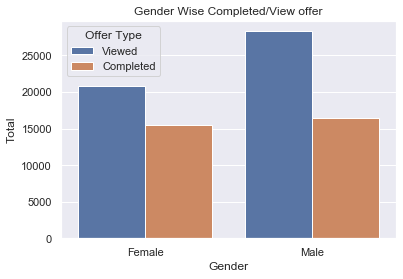

In [117]:
event_data = sns.countplot(x='gender_type', hue="event_id", data= master_data[master_data["gender_type"] != 3])
plt.title('Gender Wise Completed/View offer')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
event_data.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

# Based on Gender which offer they like?

In [118]:
replace_offer_type_column

{'offer_type': {'bogo': 1, 'informational': 2, 'discount': 3}}

In [120]:
# Mapping values to appropriate value
master_data['offer_type_id'] = master_data['offer_type_id'].map({1: 'BOGO', 2: 'Informational', 3: 'Discount'})

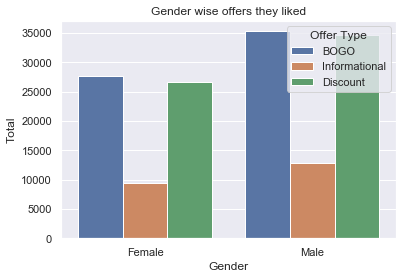

In [123]:
offer_data = sns.countplot(x='gender_type', hue="offer_type_id", data= master_data[master_data["gender_type"] != 3])
plt.title('Gender wise offers they liked')
plt.ylabel('Total')
plt.xlabel('Gender')
xlabels = ['Female', 'Male']
offer_data.set_xticklabels(xlabels)
plt.legend(title='Offer Type')
plt.show();

# Conclusion

We can see that Male gender like more BOGO offer and then Discount while compared to female also males shown interested to avail the offer